In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
prices = np.loadtxt('prices.txt').T
nInst, nt = prices.shape

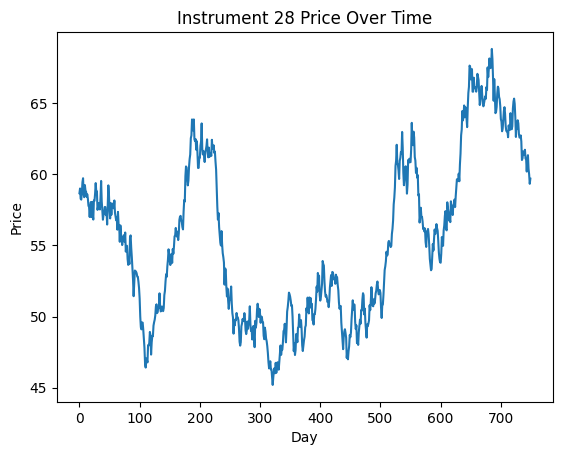

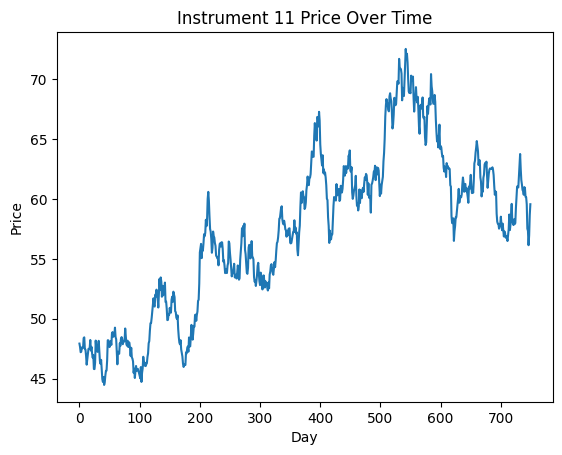

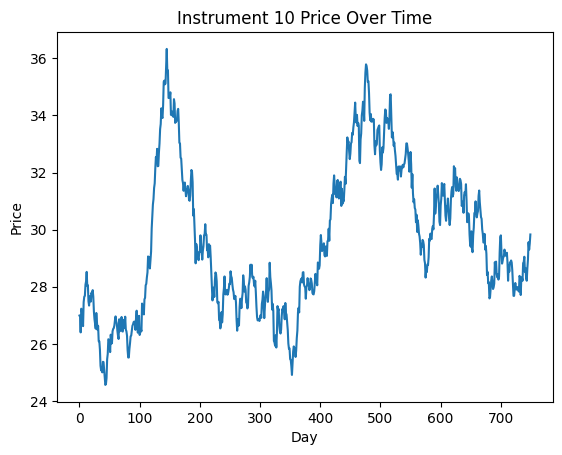

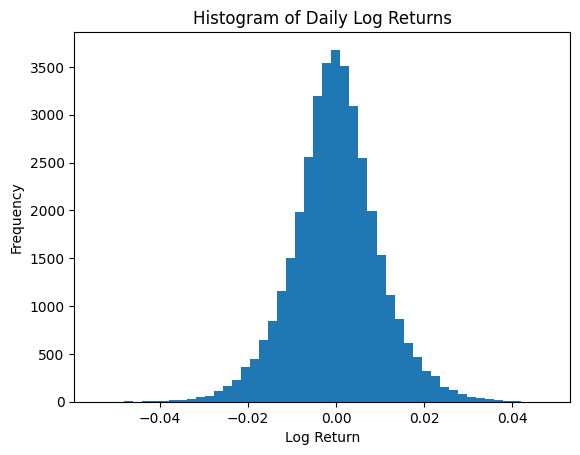

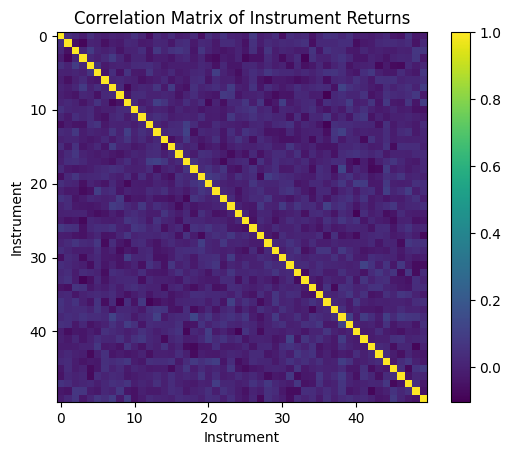

In [14]:
np.random.seed(0)
sample_inds = np.random.choice(nInst, size=3, replace=False)
for idx in sample_inds:
    plt.figure()
    plt.plot(prices[idx])
    plt.title(f"Instrument {idx} Price Over Time")
    plt.xlabel("Day")
    plt.ylabel("Price")

# 2) Histogram of daily log returns across all instruments
returns = np.diff(np.log(prices), axis=1)
plt.figure()
plt.hist(returns.flatten(), bins=50)
plt.title("Histogram of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")

# 3) Correlation matrix heatmap of instrument returns
corr = np.corrcoef(returns)
plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.title("Correlation Matrix of Instrument Returns")
plt.xlabel("Instrument")
plt.ylabel("Instrument")

plt.show()